In [ ]:
import numpy as np
import pandas as pd
from time import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import re

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

from pandas.plotting import register_matplotlib_converters, autocorrelation_plot
register_matplotlib_converters()
sns.mpl.rc("figure", figsize=(10, 5))
sns.mpl.rc("font", size=14)
from pandas.tseries.offsets import DateOffset

import warnings
warnings.filterwarnings("ignore")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


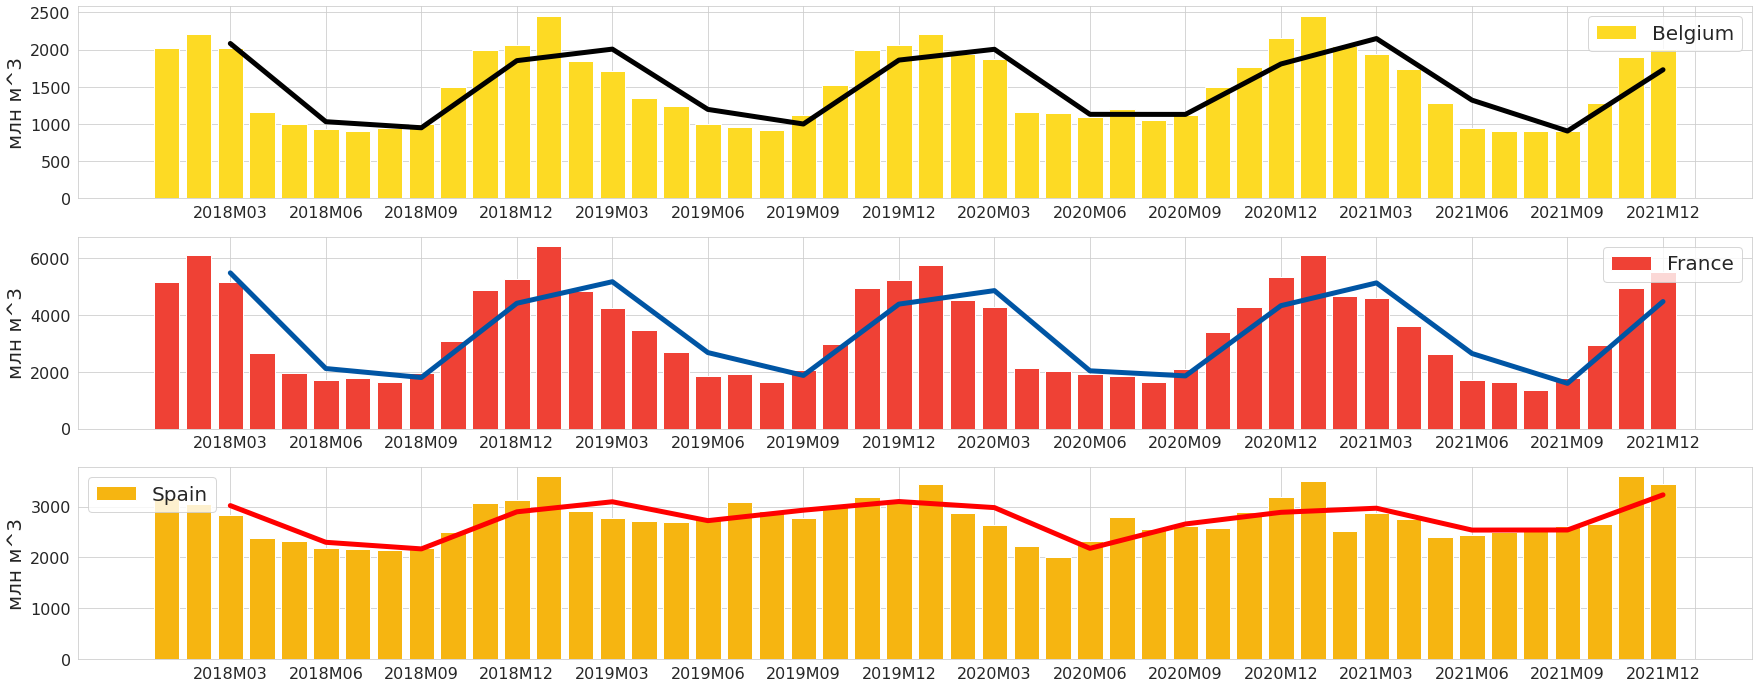

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/nrg_cb_gasm (1).xlsx'
data = pd.read_excel(file_path,'Data', header=0)
data.index = data['GEO/TIME']
data.drop('GEO/TIME', inplace=True, axis=1)
data = data.loc[['BE - Belgium','ES - Spain','FR - France'],:]
data_q = pd.read_excel(file_path,'Quarterly', header=0) # Квартальные объемы
data_q.index = data_q['GEO/TIME']
data_q.drop('GEO/TIME', inplace=True, axis=1)

plt.figure(1, figsize=(30,12))
sns.set_style('whitegrid')

plt.subplot(311)
plt.bar(data.columns[:-3], data.loc['BE - Belgium',:'2021M12'], color='#FDDA24',
               label='Belgium')  # Визуализируем график месячных объемов потребления газа на временной шкале
plt.plot(data_q.columns[:-1], data_q.loc['BE - Belgium',:'2021M12']/3, 
               c='#000000', linewidth = 5) # График 3-месячной скользящей средней
plt.ylabel('млн м^3', fontsize=20) 
plt.yticks(fontsize=16)
plt.xticks(data_q.columns, [x for x in data_q.columns[:-1]], fontsize=16)
plt.legend(fontsize=20)


plt.subplot(312)
plt.bar(data.columns[:-3], data.loc['FR - France',:'2021M12'], color='#EF4135',
               label='France')  # Визуализируем график месячных объемов потребления газа на временной шкале
plt.plot(data_q.columns[:-1], data_q.loc['FR - France',:'2021M12']/3, 
               c='#0055A4', linewidth = 5) # График 3-месячной скользящей средней
plt.ylabel('млн м^3', fontsize=20) 
plt.yticks(fontsize=16)
plt.xticks(data_q.columns, [x for x in data_q.columns[:-1]], fontsize=16)
plt.legend(fontsize=20)


plt.subplot(313)
plt.bar(data.columns[:-3], data.loc['ES - Spain',:'2021M12'], color='#f6b511',
               label='Spain')  # Визуализируем график месячных объемов потребления газа на временной шкале
plt.plot(data_q.columns[:-1], data_q.loc['ES - Spain',:'2021M12']/3, 
               c='r', linewidth = 5) # График 3-месячной скользящей средней
plt.ylabel('млн м^3', fontsize=20) 
plt.yticks(fontsize=16)
plt.xticks(data_q.columns, [x for x in data_q.columns[:-1]], fontsize=16)
plt.legend(fontsize=20)


plt.show()

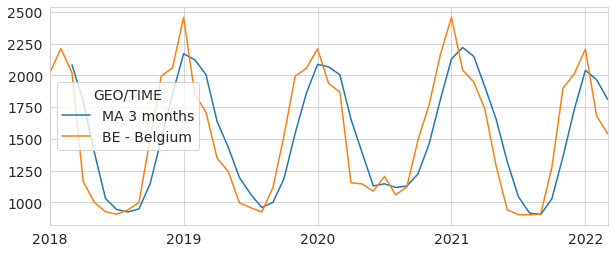

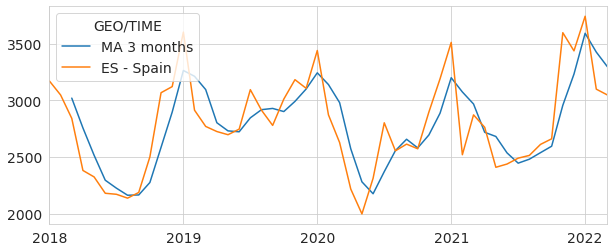

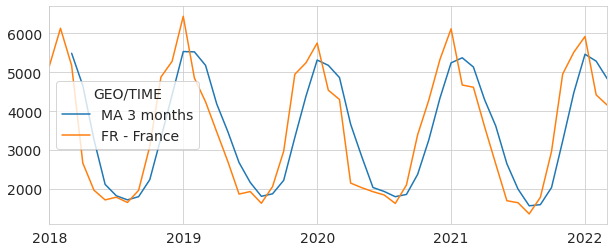

In [ ]:
# downloaded and shared the dataset with simplier graphics
file_path = '/content/drive/MyDrive/Colab Notebooks/nrg_cb_gasm (1).xlsx'
df = pd.read_excel(file_path,'Data', header=0)
data = df.iloc[:3,:]
data = data.transpose()
data.columns = data.iloc[0]
data.drop('GEO/TIME', inplace=True, axis=0)
data.index = pd.to_datetime(data.index, format='%YM%m')
# data.head()
# data['BE - Belgium'].resample('M').mean().plot(kind='bar',figsize=(16,6))
for column in ['BE - Belgium','ES - Spain','FR - France']:
  data['MA 3 months'] = data[column].rolling(3).mean()
  data[['MA 3 months',column]].plot(figsize=(10,4))
  continue
data = data[['BE - Belgium','ES - Spain','FR - France']]

In [ ]:
for column in data.columns:
  data[column] = pd.to_numeric(data[column])

<Figure size 720x288 with 0 Axes>

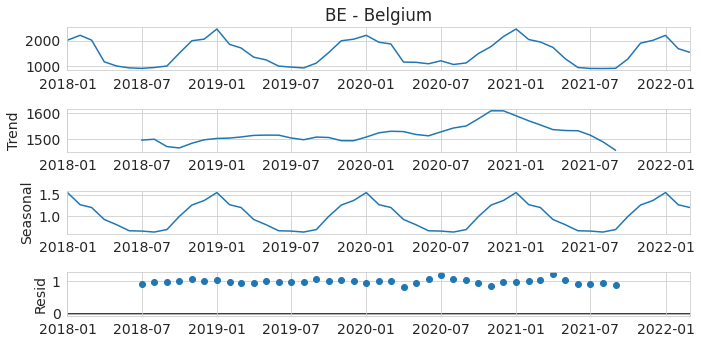

<Figure size 720x288 with 0 Axes>

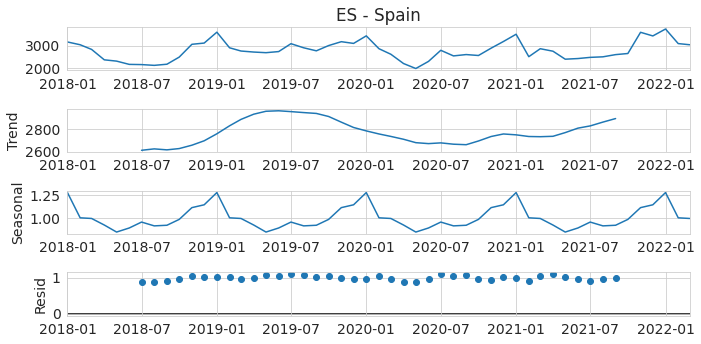

<Figure size 720x288 with 0 Axes>

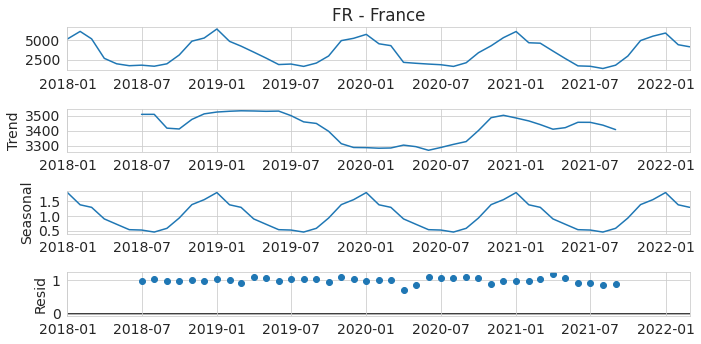

In [ ]:
for column in data.columns:
  plt.figure(figsize = (10,4))
  result = seasonal_decompose(data[column], model = 'multiplicative')
  resultmult = result.plot()
  continue

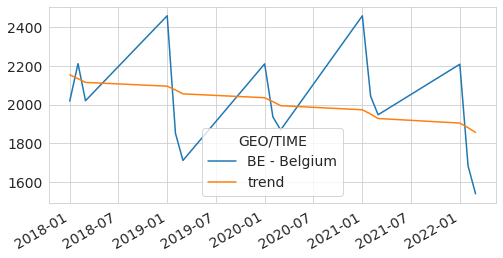

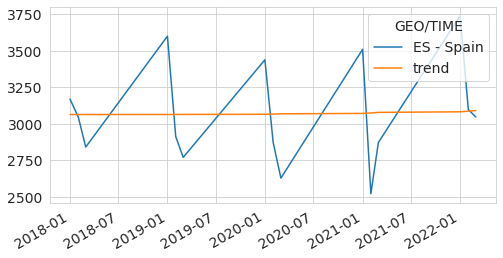

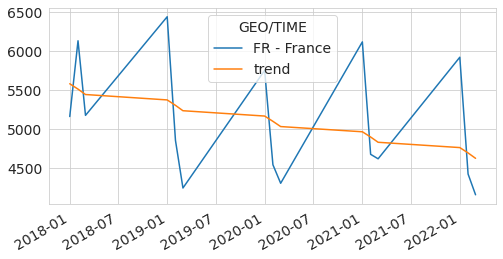

In [ ]:
# we can clearly see seasonal trends
# check first 3 months of each year
pd.options.mode.chained_assignment = None  # default='warn'
for column in data.columns:
  new_data = data[(data[column].index.quarter == 1)]
  cycle, trend = sm.tsa.filters.hpfilter(new_data[column])
  new_data['trend'] = trend
  new_data[[column,'trend']].plot(figsize = (8,4)) 
  continue

In [ ]:
# looking just at the plots above for the first quarter 2022 we can expect 
# decrease of usage for France and Belgium and same volume for Spain 
# (and as we can see the trend doesnt change for 1 quarter of 2022)
new_data[['BE - Belgium',	'ES - Spain',	'FR - France']].describe().head(4).transpose()

,count,mean,std,min
GEO/TIME,,,,
BE - Belgium,15.0,2011.060000,266.184570,1540.200
ES - Spain,15.0,3071.354600,360.242054,2520.660
FR - France,15.0,5099.572133,781.307274,4152.979


In [ ]:
data.describe().head(4).transpose()

,count,mean,std,min
GEO/TIME,,,,
BE - Belgium,51.0,1527.482353,489.700216,901.900
ES - Spain,51.0,2793.735627,416.069721,1999.000
FR - France,51.0,3513.019373,1574.381881,1356.629


In [ ]:
# comparing 1st quarter in average to yearly average data we see decreasing of STD 
# and increasing of mean values
# we can also use historical min of values for predicting future volumes

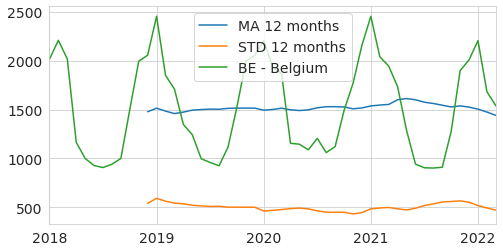

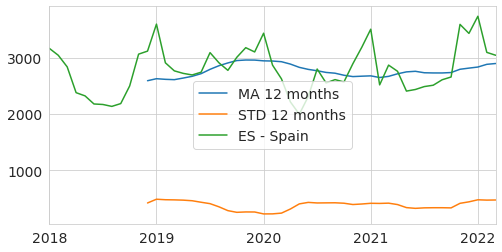

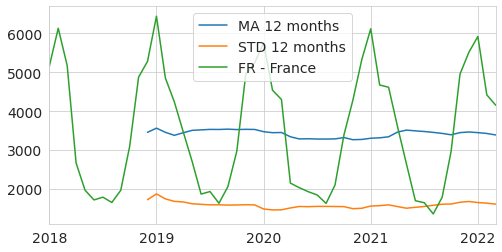

In [ ]:
for column in data.columns:
  plt.figure(figsize = (8,4))
  data[column].rolling(12).mean().plot(label='MA 12 months')
  data[column].rolling(12).std().plot(label='STD 12 months')
  data[column].plot()
  plt.legend()
  continue

In [ ]:
# to check for mean/std are no changing too much over time - data is stationary - we run a test for ADF
from statsmodels.tsa.stattools import adfuller

def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adf_check(data['BE - Belgium']) 

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.2239282970776335
p-value : 0.19767575948181682
#Lags Used : 9
Number of Observations Used : 41
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


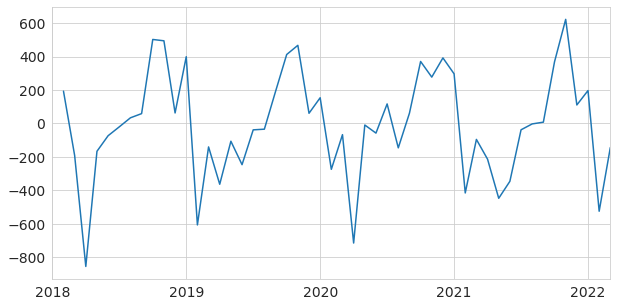

In [ ]:
data['First Difference BE'] = data['BE - Belgium']-data['BE - Belgium'].shift(1)
data['First Difference BE'].plot()

In [ ]:
adf_check(data['First Difference BE'].dropna()) # this component could be used for ML modeling analysis, unlike the raw data

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.423034168341209
p-value : 0.00027017642824366515
#Lags Used : 10
Number of Observations Used : 39
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
adf_check(data['ES - Spain'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.8863324490813556
p-value : 0.002137767227678893
#Lags Used : 2
Number of Observations Used : 48
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
adf_check(data['FR - France'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.8639130791975904
p-value : 0.04970822617729544
#Lags Used : 9
Number of Observations Used : 41
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
# we prooved that raw data (or its 1-lagged version for Belgium) is stationary and we can apply linear regression (autocorrelated ACF) function 

In [ ]:
data = data[['BE - Belgium','ES - Spain','FR - France']]
data.head()

GEO/TIME,BE - Belgium,ES - Spain,FR - France
2018-01-01,2018.0,3170.0,5159.0
2018-02-01,2211.0,3047.0,6133.0
2018-03-01,2020.0,2841.0,5174.0
2018-04-01,1166.0,2382.0,2666.0
2018-05-01,1000.0,2325.0,1967.0


BE - Belgium
ES - Spain
FR - France


<Figure size 576x288 with 0 Axes>

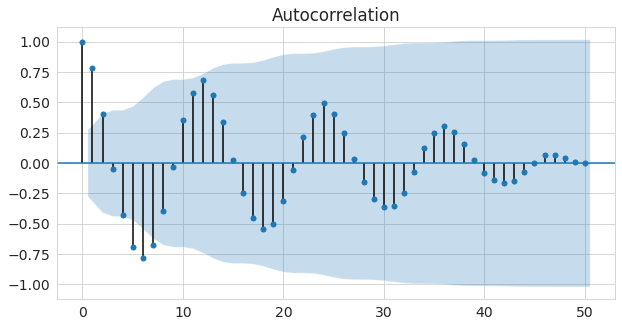

<Figure size 576x288 with 0 Axes>

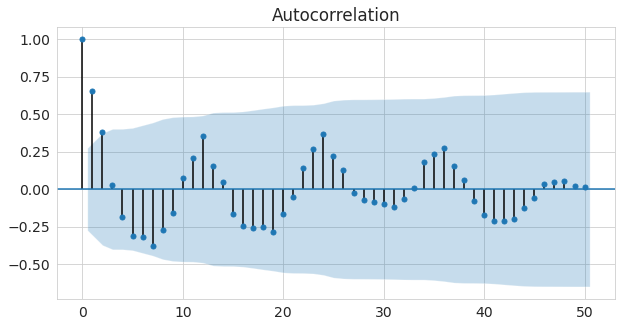

<Figure size 576x288 with 0 Axes>

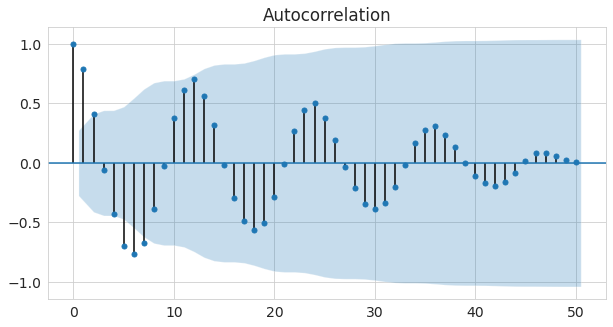

In [ ]:
# plot ACF / PACF
for column in data.columns:
  print(column)
  plt.figure(figsize = (8,4))
  acf_plot = plot_acf(data[column], lags=50) 
  continue


<Figure size 576x288 with 0 Axes>

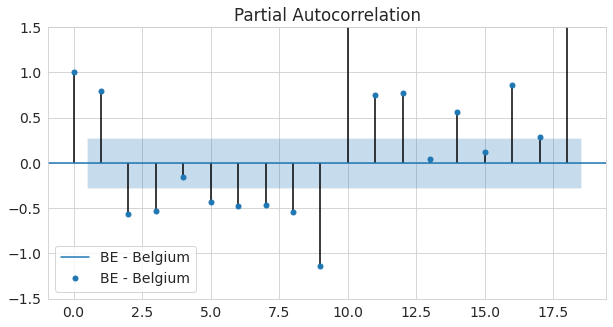

<Figure size 576x288 with 0 Axes>

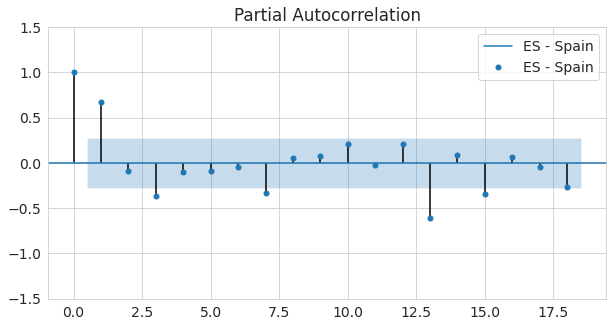

<Figure size 576x288 with 0 Axes>

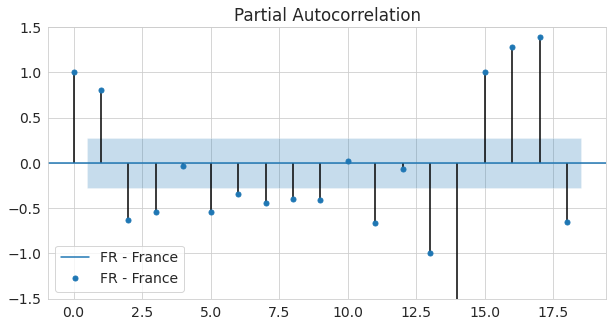

In [ ]:
for column in data.columns:
  plt.figure(figsize = (8,4))
  acf_plot = plot_pacf(data[column],label=f"{column}")
  plt.ylim([-1.5, 1.5])
  plt.legend()
  continue

In [ ]:
# based on partially auto-correlated function test  
# we can build an auto regressive model with 1,9,10,18 months lags for Belgium, 
# with 1,3,13 months lags for Spain and
# with 1,2,13,14,15,16,17 months lags for France

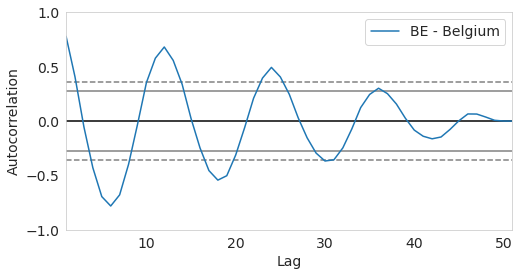

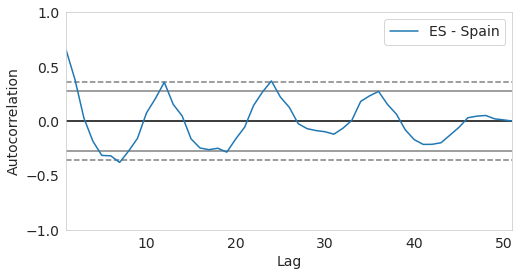

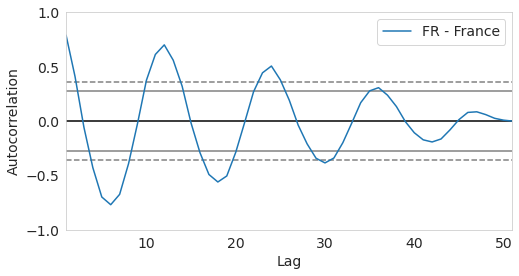

In [ ]:
for column in data.columns:
  plt.figure(figsize = (8,4))
  autocorrelation_plot(data[column].dropna(),label=f"{column}")
  plt.legend()
  continue

                            AutoReg Model Results                             
Dep. Variable:           BE - Belgium   No. Observations:                   48
Model:                    AutoReg(18)   Log Likelihood                -182.770
Method:               Conditional MLE   S.D. of innovations            107.062
Date:                Tue, 30 Aug 2022   AIC                             10.680
Time:                        14:58:04   BIC                             11.614
Sample:                    07-01-2019   HQIC                            10.979
                         - 12-01-2021                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1891.0798   1256.955      1.504      0.132    -572.506    4354.666
BE - Belgium.L1      0.4899      0.184      2.661      0.008       0.129       0.851
BE - Belgium.L2     -0.2591 

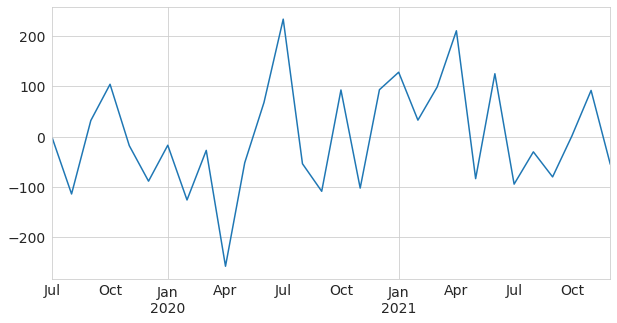

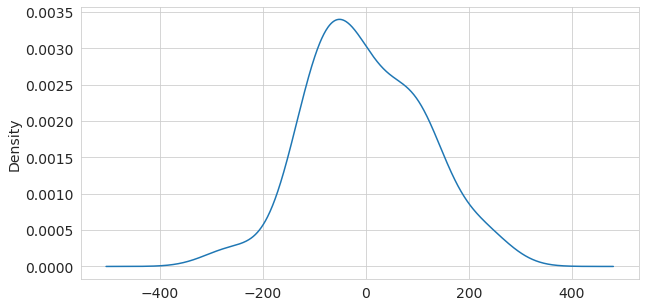

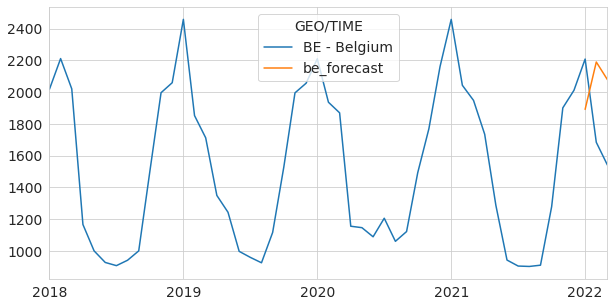

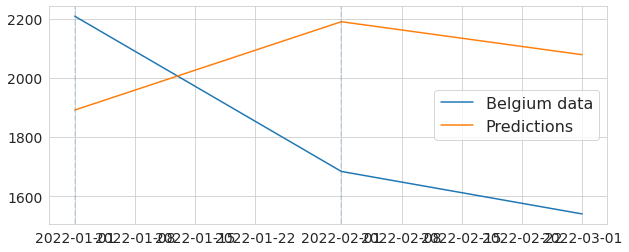

In [ ]:
# check AR model


be_model = AutoReg(be_train_data, 18, old_names=False) 
be_fit_model = be_model.fit()
print(be_fit_model.summary())

be_fit_model.resid.plot()
plt.show()

be_fit_model.resid.plot(kind='kde')
plt.show()

be_predict = be_fit_model.predict(start=predict_start_date , end=predict_end_date, dynamic= True) 
be_residuals = be_test_data - be_predict
data['be_forecast']= be_predict
data[['BE - Belgium','be_forecast']].plot(figsize=(10,5))
plt.show()

plt.figure(figsize=(10,4))
plt.plot(be_test_data)
plt.plot(be_predict)
plt.legend(('Belgium data','Predictions'),fontsize=16)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

                            AutoReg Model Results                             
Dep. Variable:            FR - France   No. Observations:                   48
Model:                    AutoReg(18)   Log Likelihood                -211.323
Method:               Conditional MLE   S.D. of innovations            277.318
Date:                Tue, 30 Aug 2022   AIC                             12.584
Time:                        14:58:05   BIC                             13.518
Sample:                    07-01-2019   HQIC                            12.882
                         - 12-01-2021                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5995.7416   2426.114      2.471      0.013    1240.646    1.08e+04
FR - France.L1      0.4209      0.175      2.404      0.016       0.078       0.764
FR - France.L2      0.0636      

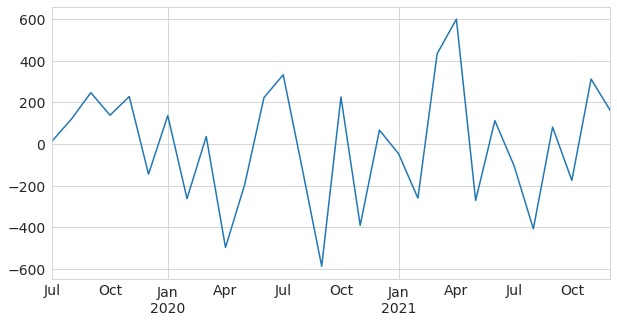

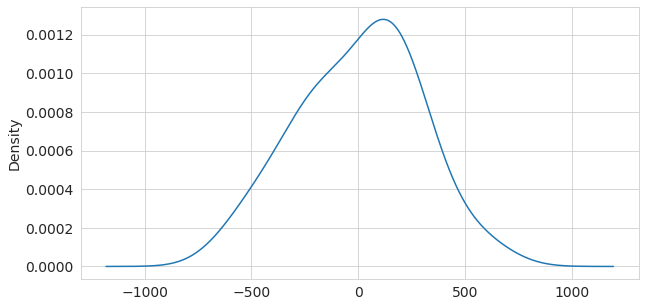

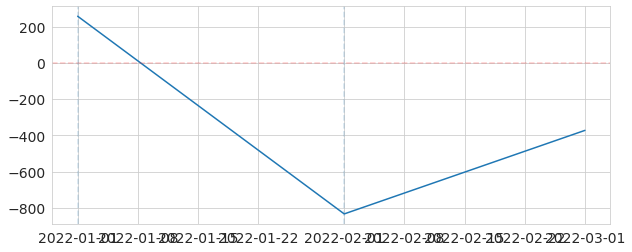

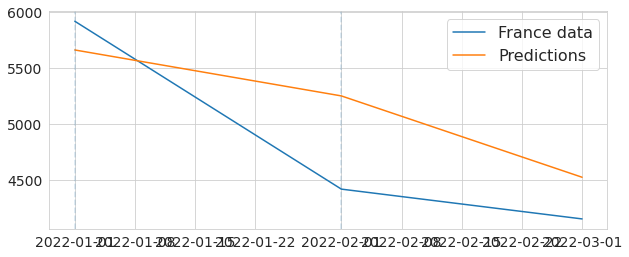

In [ ]:
fr_model = AutoReg(fr_train_data, 18, old_names=False) 
fr_fit_model = fr_model.fit()
print(fr_fit_model.summary())

fr_fit_model.resid.plot()
plt.show()

fr_fit_model.resid.plot(kind='kde')
plt.show()

fr_predict = fr_fit_model.predict(start=predict_start_date , end=predict_end_date)
fr_residuals = fr_test_data - fr_predict
plt.figure(figsize=(10,4))
plt.plot(fr_residuals)
plt.axhline (0,color='r',linestyle='--', alpha=0.2)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(fr_test_data)
plt.plot(fr_predict)
plt.legend(('France data','Predictions'),fontsize=16)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

                            AutoReg Model Results                             
Dep. Variable:             ES - Spain   No. Observations:                   48
Model:                    AutoReg(18)   Log Likelihood                -197.046
Method:               Conditional MLE   S.D. of innovations            172.301
Date:                Tue, 30 Aug 2022   AIC                             11.632
Time:                        14:58:06   BIC                             12.566
Sample:                    07-01-2019   HQIC                            11.931
                         - 12-01-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6733.8315   1664.588      4.045      0.000    3471.299    9996.364
ES - Spain.L1      0.6212      0.166      3.734      0.000       0.295       0.947
ES - Spain.L2     -0.5447      0.224

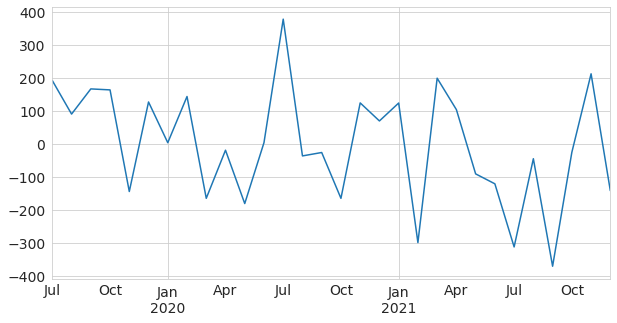

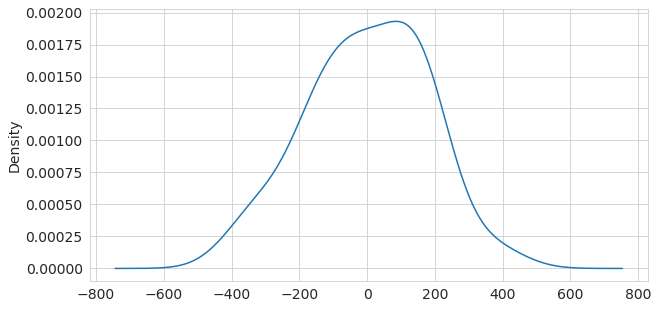

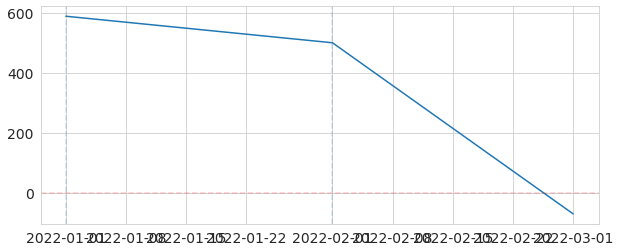

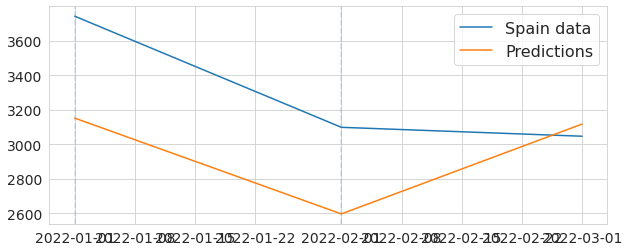

In [ ]:
es_model = AutoReg(es_train_data, 18, old_names=False) 
es_fit_model = es_model.fit()
print(es_fit_model.summary())

es_fit_model.resid.plot()
plt.show()

es_fit_model.resid.plot(kind='kde')
plt.show()

es_predict = es_fit_model.predict(start=predict_start_date , end=predict_end_date)
es_residuals = es_test_data - es_predict
plt.figure(figsize=(10,4))
plt.plot(es_residuals)
plt.axhline (0,color='r',linestyle='--', alpha=0.2)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(es_test_data)
plt.plot(es_predict)
plt.legend(('Spain data','Predictions'),fontsize=16)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

In [ ]:
print("Mean Abs Error for Belgium prediction:", round(np.mean(abs(be_residuals/be_test_data))*100,2),'%')
print("Root Mean Sqr Error for Belgium prediction:", round(np.sqrt(np.mean(be_residuals**2)),1),'\n')

print("Mean Abs Error for Spain prediction:", round(np.mean(abs(es_residuals/es_test_data))*100,2),'%')
print("Root Mean Sqr Error for Spain prediction:", round(np.sqrt(np.mean(es_residuals**2)),1),'\n')

print("Mean Abs Error for France prediction:", round(np.mean(abs(fr_residuals/fr_test_data))*100,2),'%')
print("Root Mean Sqr Error for France prediction:", round(np.sqrt(np.mean(fr_residuals**2)),1))

Mean Abs Error for Belgium prediction: 26.43 %
Root Mean Sqr Error for Belgium prediction: 463.8 

Mean Abs Error for Spain prediction: 11.41 %
Root Mean Sqr Error for Spain prediction: 448.5 

Mean Abs Error for France prediction: 10.73 %
Root Mean Sqr Error for France prediction: 547.8


In [ ]:
# ARMA model
be_frequency = data['BE - Belgium'].asfreq(pd.infer_freq(data.index))
es_frequency = data['ES - Spain'].asfreq(pd.infer_freq(data.index))
fr_frequency = data['FR - France'].asfreq(pd.infer_freq(data.index))
start_date = data.index[0]
end_date = data.index[-4]
# filtering 2018-2021 train set
be_train_data = data[start_date:end_date]['BE - Belgium']
es_train_data = data[start_date:end_date]['ES - Spain']
fr_train_data = data[start_date:end_date]['FR - France']
# filtering 2022 as a test set
be_test_data = data[end_date + timedelta(days=1):]['BE - Belgium']
es_test_data = data[end_date + timedelta(days=1):]['ES - Spain']
fr_test_data = data[end_date + timedelta(days=1):]['FR - France']
predict_start_date = data.index[-3]
predict_end_date = data.index[-1]

In [ ]:
# we try lags to 9 all againand see which models are better performing

                              ARMA Model Results                              
Dep. Variable:           BE - Belgium   No. Observations:                   48
Model:                     ARMA(3, 0)   Log Likelihood                -327.789
Method:                       css-mle   S.D. of innovations            217.783
Date:                Tue, 30 Aug 2022   AIC                            665.578
Time:                        14:58:08   BIC                            674.934
Sample:                    01-01-2018   HQIC                           669.114
                         - 12-01-2021                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1505.6670     65.864     22.860      0.000    1376.577    1634.757
ar.L1.BE - Belgium     0.9400      0.121      7.759      0.000       0.703       1.177
ar.L2.BE - Belgium  

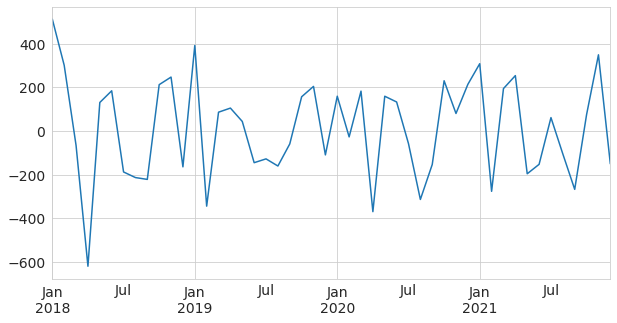

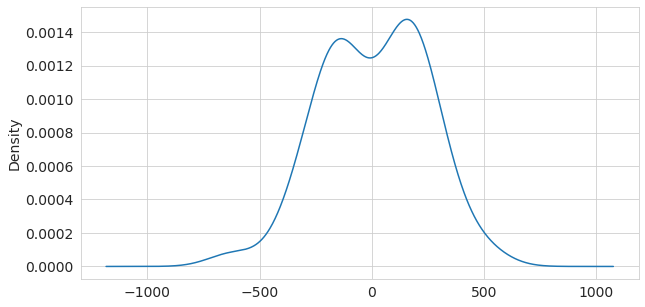

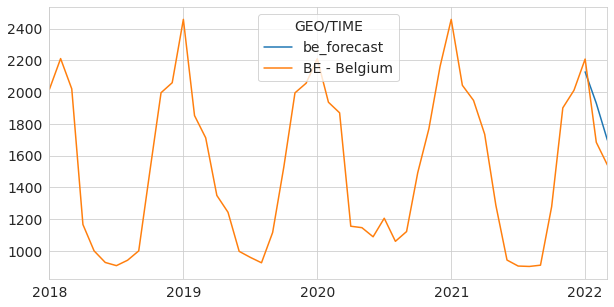

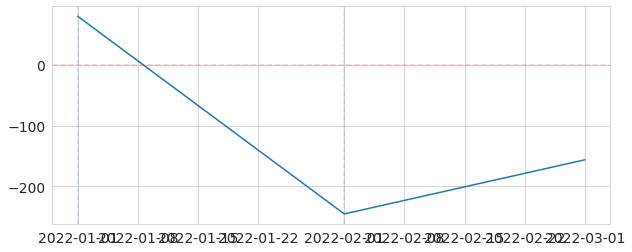

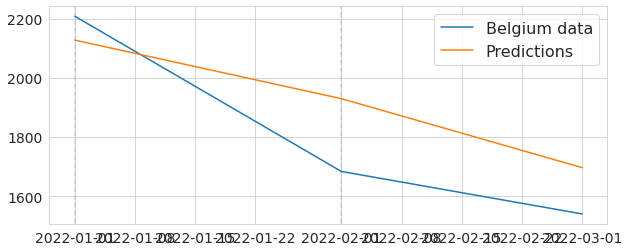

In [ ]:
be_model = ARMA(be_train_data, order=(3,0)) # lags 1 and 3 are important for Belgium (P>|z| < 0.05)
be_fit_model = be_model.fit()
print(be_fit_model.summary())

be_fit_model.resid.plot()
plt.show()

be_fit_model.resid.plot(kind='kde')
plt.show()

be_predict = be_fit_model.predict(start=predict_start_date , end=predict_end_date, dynamic= True) 
be_residuals = be_test_data - be_predict
data['be_forecast']= be_predict
data[['be_forecast','BE - Belgium']].plot(figsize=(10,5))
plt.show()

be_predict = be_fit_model.predict(start=predict_start_date , end=predict_end_date)
be_residuals = be_test_data - be_predict
plt.figure(figsize=(10,4))
plt.plot(be_residuals)
plt.axhline (0,color='r',linestyle='--', alpha=0.2)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(be_test_data)
plt.plot(be_predict)
plt.legend(('Belgium data','Predictions'),fontsize=16)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

                              ARMA Model Results                              
Dep. Variable:            FR - France   No. Observations:                   48
Model:                     ARMA(3, 0)   Log Likelihood                -380.118
Method:                       css-mle   S.D. of innovations            644.761
Date:                Tue, 30 Aug 2022   AIC                            770.236
Time:                        14:58:10   BIC                            779.592
Sample:                    01-01-2018   HQIC                           773.772
                         - 12-01-2021                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3398.1890    188.503     18.027      0.000    3028.730    3767.648
ar.L1.FR - France     0.9522      0.119      7.986      0.000       0.719       1.186
ar.L2.FR - France     0.

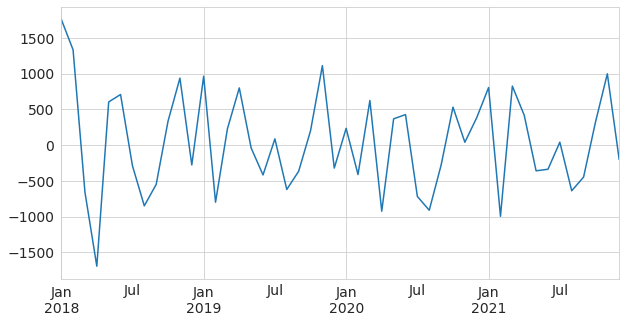

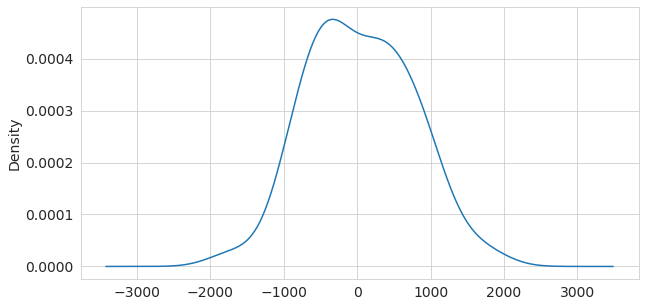

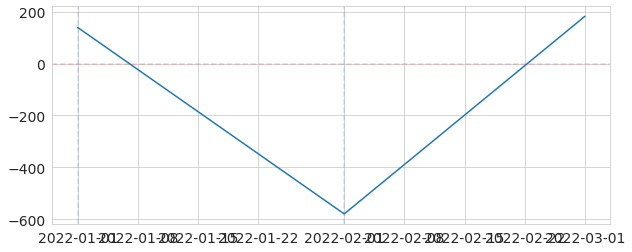

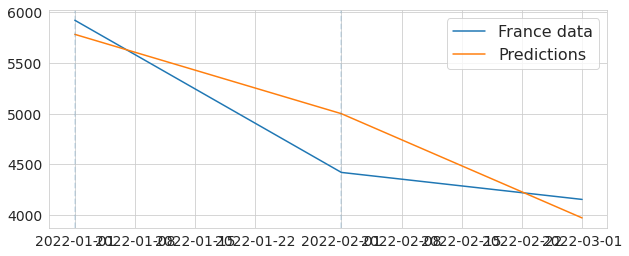

In [ ]:
fr_model = ARMA(fr_train_data, order=(3,0)) # lags 1 and 3 are important for France (P>|z| < 0.05)
fr_fit_model = fr_model.fit()
print(fr_fit_model.summary())

fr_fit_model.resid.plot()
plt.show()

fr_fit_model.resid.plot(kind='kde')
plt.show()

fr_predict = fr_fit_model.predict(start=predict_start_date , end=predict_end_date)
fr_residuals = fr_test_data - fr_predict
plt.figure(figsize=(10,4))
plt.plot(fr_residuals)
plt.axhline (0,color='r',linestyle='--', alpha=0.2)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(fr_test_data)
plt.plot(fr_predict)
plt.legend(('France data','Predictions'),fontsize=16)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

                              ARMA Model Results                              
Dep. Variable:             ES - Spain   No. Observations:                   48
Model:                     ARMA(1, 0)   Log Likelihood                -343.042
Method:                       css-mle   S.D. of innovations            305.521
Date:                Tue, 30 Aug 2022   AIC                            692.084
Time:                        14:58:12   BIC                            697.698
Sample:                    01-01-2018   HQIC                           694.206
                         - 12-01-2021                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2801.3943    123.210     22.737      0.000    2559.907    3042.882
ar.L1.ES - Spain     0.6515      0.113      5.772      0.000       0.430       0.873
                            

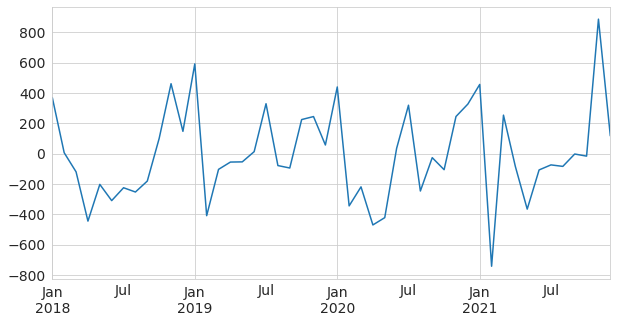

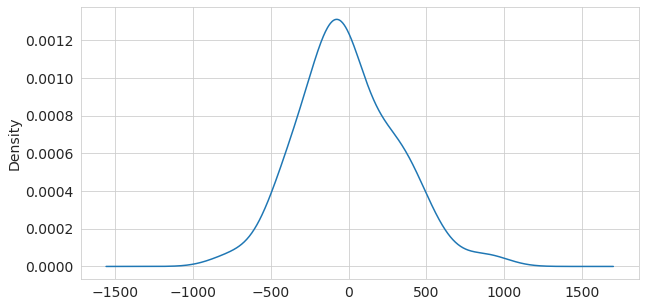

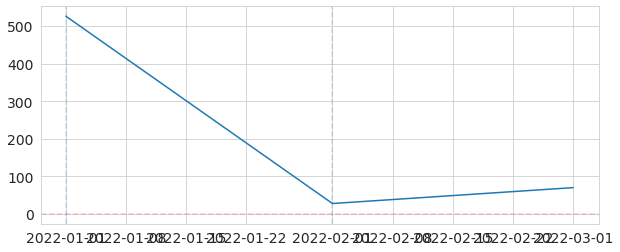

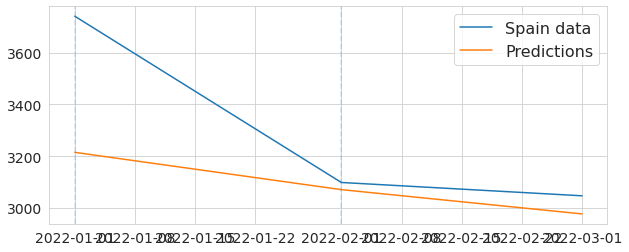

In [ ]:
es_model = ARMA(es_train_data, order=(1,0))  # lag 1 is important for Spain (P>|z| < 0.05)
es_fit_model = es_model.fit()
print(es_fit_model.summary())

es_fit_model.resid.plot()
plt.show()

es_fit_model.resid.plot(kind='kde')
plt.show()

es_predict = es_fit_model.predict(start=predict_start_date , end=predict_end_date)
es_residuals = es_test_data - es_predict
plt.figure(figsize=(10,4))
plt.plot(es_residuals)
plt.axhline (0,color='r',linestyle='--', alpha=0.2)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(es_test_data)
plt.plot(es_predict)
plt.legend(('Spain data','Predictions'),fontsize=16)
for month in range(1,3):
  plt.axvline(pd.to_datetime('2022-0'+str(month)), linestyle='--', alpha=0.2)
plt.show()

In [ ]:
print("Mean Abs Error for Belgium prediction:", round(np.mean(abs(be_residuals/be_test_data))*100,2),'%')
print("Root Mean Sqr Error for Belgium prediction:", round(np.sqrt(np.mean(be_residuals**2)),1),'\n')

print("Mean Abs Error for Spain prediction:", round(np.mean(abs(es_residuals/es_test_data))*100,2),'%')
print("Root Mean Sqr Error for Spain prediction:", round(np.sqrt(np.mean(es_residuals**2)),1),'\n')

print("Mean Abs Error for France prediction:", round(np.mean(abs(fr_residuals/fr_test_data))*100,2),'%')
print("Root Mean Sqr Error for France prediction:", round(np.sqrt(np.mean(fr_residuals**2)),1))

Mean Abs Error for Belgium prediction: 9.47 %
Root Mean Sqr Error for Belgium prediction: 174.5 

Mean Abs Error for Spain prediction: 5.75 %
Root Mean Sqr Error for Spain prediction: 306.9 

Mean Abs Error for France prediction: 6.62 %
Root Mean Sqr Error for France prediction: 360.0


In [ ]:
data = data[['BE - Belgium',	'ES - Spain','FR - France']]
be_data = data['BE - Belgium']
es_data = data['ES - Spain']
fr_data = data['FR - France']
future_dates = [data.index[-1] + DateOffset(months=x) for x in range(0,9)]
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=data.columns)
future_df = pd.concat([data,future_dates_df])
future_df.head()

GEO/TIME,BE - Belgium,ES - Spain,FR - France
2018-01-01,2018.0,3170.0,5159.0
2018-02-01,2211.0,3047.0,6133.0
2018-03-01,2020.0,2841.0,5174.0
2018-04-01,1166.0,2382.0,2666.0
2018-05-01,1000.0,2325.0,1967.0


In [ ]:
future_df.tail()

GEO/TIME,BE - Belgium,ES - Spain,FR - France
2022-07-01,NaN,NaN,NaN
2022-08-01,NaN,NaN,NaN
2022-09-01,NaN,NaN,NaN
2022-10-01,NaN,NaN,NaN
2022-11-01,NaN,NaN,NaN


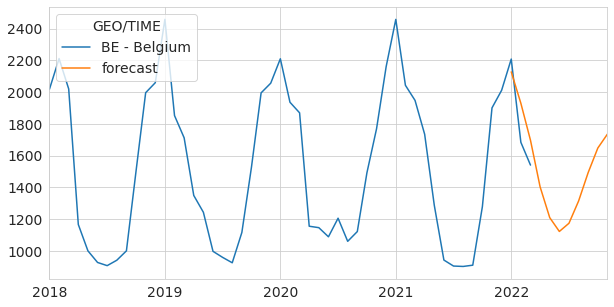

In [ ]:
future_df['forecast'] = be_fit_model.predict(start = predict_start_date, end = future_df.index[-1], dynamic=True)  
future_df[['BE - Belgium', 'forecast']].plot() 

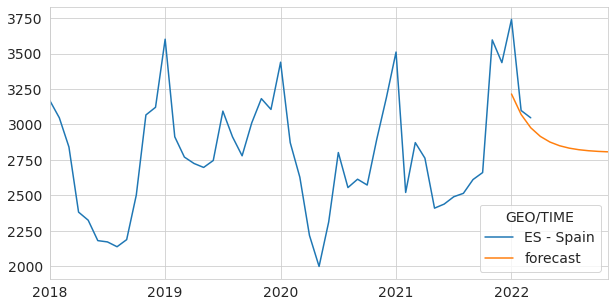

In [ ]:
future_df['forecast'] = es_fit_model.predict(start = predict_start_date, end = future_df.index[-1], dynamic=True)  
future_df[['ES - Spain', 'forecast']].plot() 

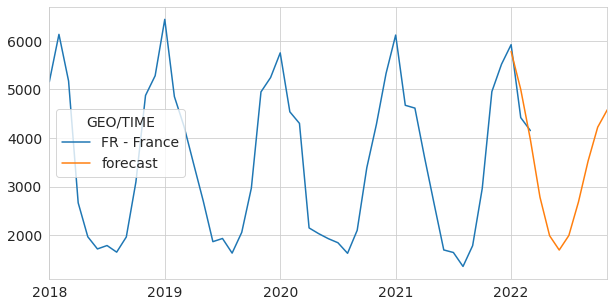

In [ ]:
future_df['forecast'] = fr_fit_model.predict(start = predict_start_date, end = future_df.index[-1], dynamic=True)  
future_df[['FR - France', 'forecast']].plot() 